# Sect 20 (v2.1): Extensions to Linear Models

- online-ds-pt-100719
- 02/27/2020


## Objectives

**DISCUSSION:**
- Discuss interactions between variables
- Discuss polynomial regressions
- Discuss the Bias vs Variance trade-off



**APPLICATION:**
- [Sect 20: Interactions Lab](https://learn.co/tracks/module-2-data-science-career-2-1/statistics-ab-testing-and-linear-regression/section-20-extensions-to-linear-models/interactions-lab)
 

- [Sect 20: Polynomial Regression Lab](https://github.com/learn-co-students/dsc-polynomial-regression-lab-online-ds-pt-100719)

## Topics Covered in Section 20


- Interactions
- Polynomial Regression    
- [Bias-Variance Trade Off](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229)

# Interactions

## What is an interaction?

When variables interact to **cause an effect** to another variable but is **not the sum of their parts**

> "An interaction is a particular property of two or more variables where they interact in a non-additive manner when affecting a third variable" - *Section recap*

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-interaction-terms-online-ds-pt-100719/master/images/new_diet_image.png">


> In our example, the interaction plot was composed out of categorical predictors (countries and diet type), but interactions can occur between categorical variables or between a mix of categorical variables and continuous variables!

### Confounding factor

>This means that the "Country" and "Diet" affect weight loss in a non-additive matter. If we're mostly interested in the effect of diet on weight loss (which seems to be plausible here), we say that "Country" is a **confounding factor** of the effect of "Diet" on weight loss.

![](images/diet_interaction.png)

### Why is important to account for interactions?

- "Not accounting for them might lead to results that are wrong."
- Replacing 2 individual columns with their interaction column can reduce the overall number of features.

- Addressing multicollinearity by creating an interaction variable instead of using the multicollinear ones.


- You'll also notice that including them when they're needed will increase your $R^2$ value!


### When should we use interactions?

- Whenever it can help the model, but not required.
- Can use in hypothesis testing as well (for ANOVAs)

## Using seaborn to view interactions

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *

fsds_1007219  v0.7.13 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


['[i] Pandas .iplot() method activated.']


In [2]:
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',0)

plt.style.use('seaborn-notebook')

In [3]:
from pandas_profiling import ProfileReport
df = fs.datasets.load_boston()
ProfileReport(df)

In [4]:
def scrub_df(data,drop_cols =[],#['id','date','view'],
                       repl_dict = {},#{'sqft_basement':('?','0.0')},
                       recast_dict = {},#{'sqft_basement':'float'},
                       fillna_dict = {},#{'waterfront':0,'yr_renovated':0},
                      verbose=1):
    """
    Performs scrubbing process on the df in the following order:
    1. Drop cols in the drop_cols list
    2. Replace values using repl_dict
    3. Recast dtypes using recast_dict
    4. Fillna using fillna_dict
    
    Args:
        data (Frame):
        drop_cols (list):
        repl_dict (dict): Key=column name, 
                        value= tuple/list with (current value, new value)
        recast_dict(dict):
        fillna_dict (dict):
    """
    df = data.copy()
    ## Drop cols
    if len(drop_cols)>0:
        for col in drop_cols:
            try:
                df.drop(col, axis=1,inplace=True)
            except Exception as e:
                print(f"[!] Erorr while dropping cols:")
                print(f"\t- Error msg: {e}")
        

    ## Replacing Values
    for col,replace in repl_dict.items():
        df[col] = df[col].replace(replace[0], replace[1])


    ## Recasting datatypes
    for col,dtype in recast_dict.items():
        df[col] = df[col].astype(dtype)
    df.dtypes

    
    ## Fill Null values / zeros
    for col,val in fillna_dict.items():
        import types
        if isinstance(val, types.FunctionType):
            fill_val = val(df[col])
        else:
            fill_val = val
        
        df[col].fillna(fill_val,inplace=True)
        
    if verbose>0:
        display(df.head())
    if verbose>1:
        display(df.info())

    return df
    

In [5]:
df = scrub_df(df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
# deal with outliers
df_outs = pd.DataFrame()
for col in df.drop(columns=['price']).columns:
    idx_outs = fs.find_outliers_Z(df[col])
    df_outs[col] = idx_outs

out_rows = df_outs.any(axis=1)
print(f"There are {out_rows.sum()} rows with outliers out of {len(df_outs)} rows.")
df_outs.sum()

There are 91 rows with outliers out of 506 rows.


CRIM        8
ZN         14
INDUS       0
CHAS       35
NOX         0
RM          8
AGE         0
DIS         5
RAD         0
TAX         0
PTRATIO     0
B          25
LSTAT       5
dtype: int64

In [7]:
df = df[~out_rows].reset_index(drop=True)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.5380,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.4690,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.4690,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.4580,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.4580,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.4580,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.5240,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.5240,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.5240,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.5240,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


### Looking for Non-linear relationships

In [8]:
## LOOKING FOR NON-LINEAR RELATIONSHIPS

from itertools import combinations,product
drop_cols = ['price']
comb_cols = list(combinations(df.drop(drop_cols,axis=1).columns,2))

cols_v_target = list(product(df.columns,['price']))
cols_v_target

[('CRIM', 'price'),
 ('ZN', 'price'),
 ('INDUS', 'price'),
 ('CHAS', 'price'),
 ('NOX', 'price'),
 ('RM', 'price'),
 ('AGE', 'price'),
 ('DIS', 'price'),
 ('RAD', 'price'),
 ('TAX', 'price'),
 ('PTRATIO', 'price'),
 ('B', 'price'),
 ('LSTAT', 'price'),
 ('price', 'price')]

In [29]:
import plotly.express as px
px.scatter_matrix(df,size_max=1,height=1000)

In [35]:
# help(df.iplot)

In [39]:
df.iplot(x='LSTAT',y='price',mode='markers')

In [40]:
# for (col1,col2) in cols_v_target:
    
#     if col1 != col2:
#         fig,ax =plt.subplots(figsize=(6,4))
#         sns.scatterplot(data=df,x=col1,y=col2,ax=ax)
#         plt.show()
#         del fig


In [41]:
# df.dtypes

In [44]:
import scipy.stats as stats
import statsmodels.api as sms
import statsmodels.formula.api as smf


def make_ols_f(df,target='price',cat_cols = [],
               col_list=None, show_summary=True,exclude_cols=[]):
    
    if col_list is None:
        col_list = list(df.drop(target,axis=1).columns)
        
    ## remove exclude cols
    [col_list.remove(ecol) for ecol in exclude_cols if ecol in col_list]

    features = '+'.join(col_list)


    for col in cat_cols:
        features = features.replace(col,f"C({col})")



    formula = target+'~'+features #target~predictors
    print(formula)

    model = smf.ols(formula=formula, data=df).fit()
    
    if show_summary:
        display(model.summary())

    return model

## plot_model_columns
# def plot_model_columns(df)


## diagnostic function

def diagnose_model(model):
    resids = model.resid
    
    fig,ax = plt.subplots(ncols=2,figsize=(10,5))
    sms.qqplot(resids, stats.distributions.norm,
              fit=True, line='45',ax=ax[0])
    xs = np.linspace(0,1,len(resids))
    ax[1].scatter(x=xs,y=resids)
    
    return fig,ax 

price~CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+B+LSTAT


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     97.37
Date:                Sun, 01 Mar 2020   Prob (F-statistic):          7.59e-111
Time:                        17:17:38   Log-Likelihood:                -1172.6
No. Observations:                 415   AIC:                             2371.
Df Residuals:                     402   BIC:                             2424.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.9707      5.492      4.729      0.000      15.173      36.768
CRIM          -0.1532      0.075     -2.043      0.042      -0.301      -0.006
ZN             0.0056      0.015      0.384      0.701      -0.023       0.034
INDUS          0.0173      0.056      0.308      0.758      -0.093       0.128
CHAS        3.013e-13   6.44e-14      4.677      0.000    1.75e-13    4.28e-13
NOX          -11.5783      3.913     -2.959      0.003     -19.271      -3.885
RM             5.0607      0.473     10.709      0.000       4.132       5.990
AGE           -0.0214      0.012     -1.722      0.086      -0.046       0.003
DIS           -1.2203      0.197     -6.189      0.000      -1.608      -0.833
RAD            0.2508      0.068      3.680      0.000       0.117       0.385
TAX           -0.0119      0.003     -3.456      0.001      -0.019      -0.005
PTRATIO       -0.9156      0.124     -7.407      0.000      -1.159      -0.673
B              0.0055      0.004      1.277      0.202      -0.003       0.014
LSTAT         -0.4361      0.057     -7.700      0.000      -0.547      -0.325
==============================================================================
Omnibus:                      227.699   Durbin-Watson:                   1.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2516.429
Skew:                           2.102   Prob(JB):                         0.00
Kurtosis:                      14.308   Cond. No.                     1.92e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.53e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2489e438>,
       dtype=object))

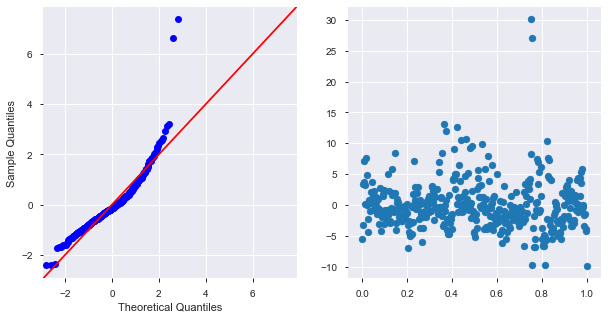

In [15]:
model = make_ols_f(df,target='price')
diagnose_model(model)

In [45]:
from sklearn.preprocessing import StandardScaler
scale_cols = df.drop(columns=['price']).columns


scaler = StandardScaler()
X = scaler.fit_transform(df[scale_cols])
X

array([[-0.50009668,  0.42727822, -1.25466328, ..., -1.48379449,
         0.43991388, -1.1282211 ],
       [-0.49580542, -0.48858069, -0.55367539, ..., -0.312853  ,
         0.43991388, -0.48493501],
       [-0.49580951, -0.48858069, -0.55367539, ..., -0.312853  ,
         0.36091635, -1.27512537],
       ...,
       [-0.4889668 , -0.48858069,  0.16203913, ...,  1.18595212,
         0.43991388, -1.02616129],
       [-0.47898384, -0.48858069,  0.16203913, ...,  1.18595212,
         0.37295037, -0.89626698],
       [-0.49169611, -0.48858069,  0.16203913, ...,  1.18595212,
         0.43991388, -0.67977647]])

In [46]:
df[scale_cols] = X
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,-0.500097,0.427278,-1.254663,0.0,-0.083120,0.503296,-0.077906,0.120954,-0.938612,-0.607776,-1.483794,0.439914,-1.128221,24.0
1,-0.495805,-0.488581,-0.553675,0.0,-0.708718,0.251194,0.410713,0.567909,-0.816465,-0.943176,-0.312853,0.439914,-0.484935,21.6
2,-0.495810,-0.488581,-0.553675,0.0,-0.708718,1.501880,-0.224135,0.567909,-0.816465,-0.943176,-0.312853,0.360916,-1.275125,34.7
3,-0.494771,-0.488581,-1.273808,0.0,-0.808451,1.195757,-0.769819,1.125951,-0.694319,-1.067398,0.108686,0.395854,-1.443679,33.4
4,-0.487272,-0.488581,-1.273808,0.0,-0.808451,1.439673,-0.470228,1.125951,-0.694319,-1.067398,0.108686,0.439914,-1.074098,36.2
5,-0.495286,-0.488581,-1.273808,0.0,-0.808451,0.265928,-0.309732,1.125951,-0.694319,-1.067398,0.108686,0.385955,-1.092655,28.7
6,-0.483338,0.147432,-0.435862,0.0,-0.210053,-0.418348,-0.027974,0.870294,-0.450027,-0.514609,-1.530632,0.414681,0.023818,22.9
7,-0.471837,0.147432,-0.435862,0.0,-0.210053,-0.156424,1.024162,1.069031,-0.450027,-0.514609,-1.530632,0.439914,1.062972,27.1
8,-0.458202,0.147432,-0.435862,0.0,-0.210053,-1.042054,1.163258,1.136092,-0.450027,-0.514609,-1.530632,0.240576,2.729949,16.5
9,-0.466625,0.147432,-0.435862,0.0,-0.210053,-0.431444,0.660373,1.395979,-0.450027,-0.514609,-1.530632,0.242129,0.745968,18.9


price~CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+B+LSTAT


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     97.37
Date:                Sun, 01 Mar 2020   Prob (F-statistic):          7.59e-111
Time:                        17:26:14   Log-Likelihood:                -1172.6
No. Observations:                 415   AIC:                             2371.
Df Residuals:                     402   BIC:                             2424.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.3540      0.204    109.804      0.000      21.954      22.754
CRIM          -0.7495      0.367     -2.043      0.042      -1.471      -0.028
ZN             0.1099      0.286      0.384      0.701      -0.453       0.672
INDUS          0.1175      0.382      0.308      0.758      -0.633       0.868
CHAS        6.424e-16   1.45e-16      4.419      0.000    3.57e-16    9.28e-16
NOX           -1.2770      0.432     -2.959      0.003      -2.126      -0.429
RM             3.0914      0.289     10.709      0.000       2.524       3.659
AGE           -0.6001      0.348     -1.722      0.086      -1.285       0.085
DIS           -2.3947      0.387     -6.189      0.000      -3.155      -1.634
RAD            2.0536      0.558      3.680      0.000       0.957       3.151
TAX           -1.9228      0.556     -3.456      0.001      -3.017      -0.829
PTRATIO       -1.9547      0.264     -7.407      0.000      -2.474      -1.436
B              0.2844      0.223      1.277      0.202      -0.153       0.722
LSTAT         -2.8200      0.366     -7.700      0.000      -3.540      -2.100
==============================================================================
Omnibus:                      227.699   Durbin-Watson:                   1.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2516.429
Skew:                           2.102   Prob(JB):                         0.00
Kurtosis:                      14.308   Cond. No.                     1.57e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.01e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ac799e8>,
       dtype=object))

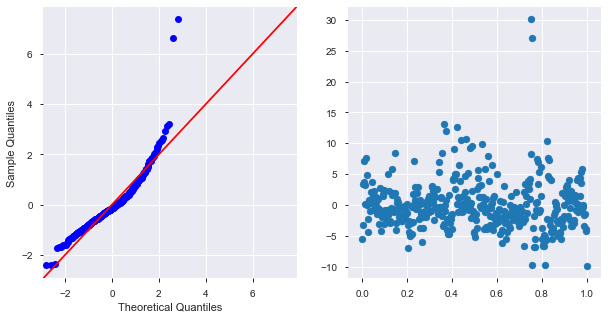

In [47]:
model = make_ols_f(df,target='price')
diagnose_model(model)

In [48]:
# target = 'price'
# col_list=['lat']
# col=col_list[0]
# exp=3

# df_poly = df[[col,target]].copy()

# exp_col =f"{col}_{exp}" 
# df_poly[exp_col] = df_poly[col]**exp

# make_ols_f(df_poly,target=target,cat_cols=[],col_list=[col])
# plt.figure()
# df_poly.plot(kind='scatter',x=col,y=target)
# plt.show()


In [49]:

# plt.figure()
# df_poly.plot(kind='scatter',x=exp_col,y=target)
# make_ols_f(df_poly,target=target,cat_cols=[],col_list=[exp_col])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
# target = 'price'
# col_list=['lat']
# exp = 4
# for col in col_list:
    
#     y = df[target].copy()
#     X = df[[col]].copy()
    
# #     df_poly = pd.concat([X,y],axis=1)
#     reg = LinearRegression()
#     reg.fit(X,y)
#     r2 =r2_score(y, reg.predict(X))
#     print(r2)
    
#     fig,ax = plt.subplots()
#     ax.scatter(X,y)
#     ax.set(xlabel=col,ylabel=target)
#     ax.plot(X,reg.predict(X),color='red')
#     plt.show()
    
    
    
#     y = df[target].copy()
#     X = df[[col]].copy()

#     from sklearn.preprocessing import PolynomialFeatures
#     poly = PolynomialFeatures(exp)
#     X = poly.fit_transform(X)
#     reg = LinearRegression()
    
#     reg.fit(X,y)
#     r2 =r2_score(y, reg.predict(X))
#     print(r2)
    
#     fig,ax = plt.subplots()
#     ax.scatter(df[[col]],y)
#     ax.set(xlabel=col,ylabel=target)
#     ax.plot(df[[col]],reg.predict(X),color='red')
#     plt.show()
    
# #     exp_col =f"{col}_{exp}" 
# #     df_poly[exp_col] = df_poly[col]**exp

# # #     make_ols_f(df_poly,target=target,cat_cols=[],col_list=[col])


    
# #     plt.figure()
# #     df_poly.plot(kind='scatter',x=exp_col,y=target)
# #     make_ols_f(df_poly,target=target,cat_cols=[],col_list=[exp_col])

In [ ]:
# Generate a mask for the upper triangle

def get_heatmap_mask(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)]=True
    return mask



In [ ]:
corr=df.corr()

fig, ax = plt.subplots(figsize=(20,20))
mask = get_heatmap_mask(df.corr())
sns.heatmap(df.corr(),cmap='Reds',annot=True,ax=ax,mask=mask)

In [ ]:
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr = df.drop(columns=['price']).corr()
corrtf = np.abs(corr>0.7)
s = corrtf.unstack()

sig_multi = s[s==True].reset_index()
sig_multi

In [ ]:
multi_cols = sig_multi[['level_0','level_1']].values
multi_cols

In [ ]:
# for (col1,col2) in multi_cols:
#     if col1 != col2:
#         fig,ax = plt.subplots(ncols=3,figsize=(10,4))
#         sns.regplot(data=df,x=col1,y='price',ax=ax[0])
#         sns.regplot(data=df,x=col2,y='price',ax=ax[1])
#         sns.scatterplot(data=df,x=col1,y=col2,ax=ax[2])
# #         ax[2].set(ylim=df[col2]())
#         plt.tight_layout()
#         plt.show()
#         del fig

In [ ]:
# df_interactions = pd.DataFrame()
# df_interactions['price']  =df['price'].copy()
# for (col1,col2) in multi_cols:
#     if col1 != col2:
#         fig,ax = plt.subplots(ncols=2)
#         sns.regplot(data=df,x=col1,y='price',ax=ax[0])
#         sns.regplot(data=df,x=col2,y='price',ax=ax[1])

#         fig, ax = plt.subplots(ncols=2,figsize=(12,4))

#         df.plot(kind='scatter',x=col1,y=col2,ax=ax[0])
#         ax[0].set(title=f"{col1} vs {col2}")
        
#         ixn_col = f"{col1}_X_{col2}"
#         df_interactions[ixn_col] = df[col1] * df[col2]
#         df_interactions.plot(kind='scatter',x=ixn_col,y='price',ax=ax[1])
#         ax[1].set(title=f"{ixn_col} vs 'price'")
#         plt.tight_layout()
#         plt.show()
#         del fig
    
# df_interactions.head(3)

In [ ]:
from sklearn.preprocessing import StandardScaler
scale_cols = df.drop(columns=['price']).columns
scaler = StandardScaler()
X = scaler.fit_transform(df[scale_cols])
X = pd.DataFrame(X,columns=scale_cols)
y = df['price'].copy()
X



In [ ]:
df = pd.concat([X,y],axis=1)
df.isna().sum()


------------------------------------------------------------
price~LSTAT


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     496.0
Date:                Sun, 01 Mar 2020   Prob (F-statistic):           9.34e-73
Time:                        17:27:50   Log-Likelihood:                -1291.6
No. Observations:                 415   AIC:                             2587.
Df Residuals:                     413   BIC:                             2595.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.3540      0.268     83.541      0.000      21.828      22.880
LSTAT         -5.9596      0.268    -22.272      0.000      -6.486      -5.434
==============================================================================
Omnibus:                      137.092   Durbin-Watson:                   1.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              376.399
Skew:                           1.593   Prob(JB):                     1.84e-82
Kurtosis:                       6.408   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

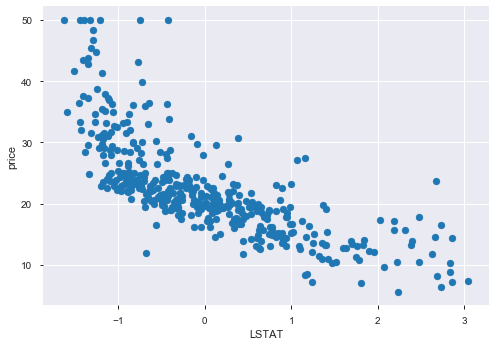


------------------------------------------------------------
price~CRIM


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     87.71
Date:                Sun, 01 Mar 2020   Prob (F-statistic):           4.97e-19
Time:                        17:27:50   Log-Likelihood:                -1415.4
No. Observations:                 415   AIC:                             2835.
Df Residuals:                     413   BIC:                             2843.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.3540      0.361     62.001      0.000      21.645      23.063
CRIM          -3.3766      0.361     -9.365      0.000      -4.085      -2.668
==============================================================================
Omnibus:                      129.255   Durbin-Watson:                   0.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              331.834
Skew:                           1.530   Prob(JB):                     8.77e-73
Kurtosis:                       6.135   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

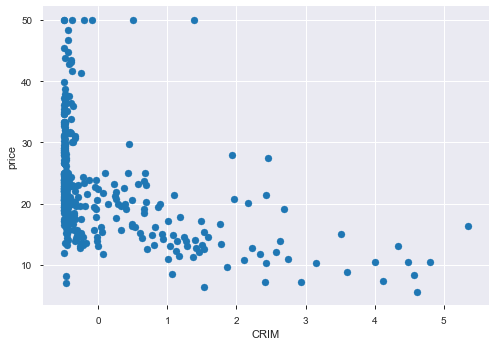


------------------------------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     31.89
Date:                Sun, 01 Mar 2020   Prob (F-statistic):           3.04e-08
Time:                        17:27:50   Log-Likelihood:                -1439.9
No. Observations:                 415   AIC:                             2884.
Df Residuals:                     413   BIC:                             2892.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.0963      0.404     57.106      0.000      22.301      23.891
LSTAT:CRIM    -1.3658      0.242     -5.647      0.000      -1.841      -0.890
==============================================================================
Omnibus:                      102.378   Durbin-Watson:                   0.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.872
Skew:                           1.330   Prob(JB):                     5.37e-45
Kurtosis:                       5.172   Cond. No.                         1.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

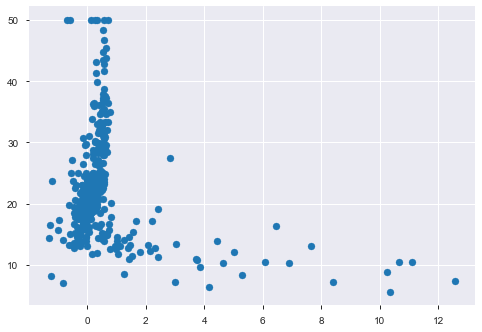

In [52]:
target='price'
col1 = 'lat'
col2='long'

def model_ols_interaction(df,col1 = 'lat',col2='long',target='price'):
#     eqns = [f'{target}~{col1}',
#             f'{target}~{col2}',
#             f'{target}~{col1}+{col2}+{col1}:{col2}']
    columns = [col1,col2]

    ## model columns alone
    for col in columns:
        print('\n'+'---'*20)
        formula = target+'~'+col
        print(formula)
        model =smf.ols(formula,df).fit()
        display(model.summary())
        plt.scatter(df[col],df[target])
        plt.xlabel(col)
        plt.ylabel(target)
        plt.show()
        
        
    ## model interaction 
    print('\n'+'---'*20)
    formula=target+ '~' + f"{col1}:{col2}"  
    model = smf.ols(formula,df).fit()
    display(model.summary())
    
    
    X = df[col1]*df[col2]
    y = df[target]
    plt.scatter(X,y)
    plt.show()
model_ols_interaction(df,'LSTAT','CRIM')

In [ ]:
model = make_ols_f(df)
diagnose_model(model)

In [ ]:
# df = fs.datasets.load_autompg()
# # display(df.head(),df.dtypes)
# df.info()

https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6

- `sns.factorplot`
- `sns.FacetGrid`

In [ ]:
# # mpl.rcParams['figure.figsize'] = (10,6)
# # fig,ax = plt.subplots()
# ffig = sns.catplot(data=df, x='horsepower',y='mpg',
#                   hue='origin',kind='point',aspect=3,scale=0.6)
# ffig.ax.set_xticklabels(ffig.ax.get_xticklabels(),rotation=45,
#                        ha='right',size=10);

# # display(fs.get_methods_attributes_df(ffig))

In [ ]:
# ffig = sns.catplot(data=df, x='horsepower',y='mpg',
#                   col='origin',kind='point',scale=0.4)


In [ ]:
g = sns.FacetGrid(df,col='origin')
g.map(sns.distplot,"mpg")

In [ ]:
g = sns.FacetGrid(df, col='origin')
g.map(sns.regplot, "horsepower",'mpg',scatter_kws={'s':16})

In [ ]:
# sns.regplot(data=df,x='horsepower',y='mpg')#,color='origin')

# Polynomial Regressions

Remember we started with (multiple) linear equation:

$$ \large \hat{y} = w_0 + w_1  x_1 + w_2  x_2 + ... + w_N  x_N $$
$$ \large \hat{y} = \sum_{n=0}^{N} w_n x_n $$


**Knowledge check:** Why is this "linear"?

## Making it more complex!

In [ ]:
df = fs.datasets.load_yields(version='other')
display(df.head())

In [ ]:
y = df['Yield']

X = df.drop(columns=['Yield'])


plt.scatter(X, y, color='green')
plt.xlabel('Temperature')
plt.ylabel('Yield');

$\large \hat y = \hat \beta_0 + \hat \beta_1x $ 

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
plt.scatter(X, y, color='green')
plt.plot(X, reg.predict(X))
plt.xlabel('Temperature')
plt.ylabel('Yield');


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y, reg.predict(X)), r2_score(y, reg.predict(X))

### A quadratic relationship
$\large \hat y = \hat \beta_0 + \hat \beta_1x + \hat \beta_2 x^2$ 

In [ ]:
# fig,ax = plt.subplots()
# ax = df.plot(kind='scatter',x='Temp',y='Yield',sizes=[50],ax=ax)
# ax.plot(df['Temp'], reg.predict(df[['Temp']]))

In [ ]:
X['Temp_sq'] = X['Temp']**2
X.head()

In [ ]:
reg_q = LinearRegression().fit(X, y)
plt.scatter(X['Temp'], y, color='green')
plt.plot(X['Temp'], reg_q.predict(X))
plt.xlabel('Temperature')
plt.ylabel('Yield');

In [ ]:
mean_squared_error(y, reg_q.predict(X)),r2_score(y, reg_q.predict(X))

In [ ]:
xs = np.linspace(0,100)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

n_poly = 5
def get_poly_features(df,transform_col='Temp',target_col='Yield',
                     n_poly=5):
    polyfeat = PolynomialFeatures(n_poly)
    col_names = [f'{transform_col}^{i}' for i in range(n_poly+1)]

    X_poly = polyfeat.fit_transform(df[[transform_col]])
    df_poly = pd.DataFrame(X_poly,columns=col_names)
    df_poly[target_col] = df[target_col].copy()
    df_poly.dropna(inplace=True)
    return df_poly

Imagine making this (start with just one variable):

$$ \large \hat{y} = \beta_0 + \beta_1  x + \beta_2  x^2 + ... + \beta_N  x^N $$
$$ \large \hat{y} = \sum_{n=0}^{N} \beta_n x^n $$

In [ ]:
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def model_poly_data(df_poly,n_poly=5, fig_xcol='Temp^1',target_col='Yield'):

    X = df_poly.drop(columns=[target_col]).copy()
    y = df_poly[target_col].copy()
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=123)
    poly_reg = LinearRegression()#normalize=True)
    poly_reg.fit(X_train,y_train)
    
    y_hat_train =  poly_reg.predict(X_train)
    y_hat_test =  poly_reg.predict(X_test)
    
    r2_train = r2_score(y_train, y_hat_train)
    r2_test = r2_score(y_test,y_hat_test)
    
    print(f'[i] For polynomial features = {n_poly}:')
    print(f"\tTraining R2: {round(r2_train,4)}")
    print(f"\tTest R2: {round(r2_test,4)}")
    
    fig,ax = plt.subplots()
    df_poly.plot(kind='scatter',x=fig_xcol,y=target_col,sizes=[50],ax=ax)
    ax.plot(df_poly[fig_xcol], poly_reg.predict(X))
    
    plot_r2 = r2_score(y, poly_reg.predict(X))
    ax.set_title(f"Predictions From Poly={n_poly}: R2={round(plot_r2,3)}")
#     plt.scatter(X_test[fig_xcol], y_test)
#     plt.plot(X_test[fig_xcol],y_hat_test)
    return {'train_test_split': [X_train,X_test,y_train,y_test],
           'preds': {'train':y_hat_train,
                    'test':y_hat_test}}


# # def plot_poly():
#     fig,ax = plt.subplots()
#     df_poly.plot(kind='scatter',x=orig_data_col,y=target_col,sizes=[50],ax=ax)
    
#     ax.plot(df_poly[orig_data_col], preds)
    
#     ax.set_title(f"Predictions From Poly={n_poly}: R2={round(r2,3)}")
#     return fig,ax

from ipywidgets import interact

@interact
def show_poly_results(N=(1,10)):
# N =3

    df_poly = get_poly_features(df,n_poly=N,transform_col='Temp',target_col='Yield',)
#     display(df_poly.head())

    res=model_poly_data(df_poly,n_poly=N)
    # plot_poly()

In [ ]:


n_polys = [2,3,4,6,8,10]
for n in n_polys:
    kws = dict(n_poly=n)
    df_poly = get_poly_features(df,**kws)
    res = model_poly_data(df_poly,**kws)
    

In [ ]:
#     res[]
res['train_test_split']
#     model_and_plot_poly(df_poly,**kws)

![](https://github.com/learn-co-students/dsc-2-24-05-polynomial-regression-online-ds-sp-000/raw/master/index_files/index_23_0.png)

![](https://github.com/learn-co-students/dsc-2-24-05-polynomial-regression-online-ds-sp-000/raw/master/index_files/index_28_0.png)

For more general (multiple variables):

$$ \large \hat{y} = \beta_{0,0} + \sum_{i=0}^{N} \beta_{1,i} x_1^i + \sum_{i=0}^{N} \beta_{2,i} x_2^i + ... + \sum_{i=0}^{N} \beta_{M,i} x_M^i$$ 

$$ \large \hat{y} = \sum_{i=0}^{N}\sum_{j=0}^{M} \beta_{j,i} x_j^i $$ 


# Bias-Variance Trade Off

## Underfitting and Overfitting

Let's formalize this:


> *Underfitting* happens when a model cannot learn the training data, nor can it generalize to new data.

The simple linear regression model fitted earlier was an underfit model.

> *Overfitting* happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data 

## The Bias-Variance Trade Off


Another perspective on this problem of overfitting versus underfitting is the bias-variance tradeoff. 

We can break down our error term (the mean squared error) as the sum of 3 sources of error: 

- *bias*
- *variance*, and
- *irreducible error* 

 

$$ \large \text{MSE} = \text{Bias}(\hat{f}(x))^2 + \text{Var}(\hat{f}(x)) + \sigma^2$$
- The derivation of this can be found [here](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation).

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-bias-variance-trade-off-online-ds-pt-100719/master/images/new_bias_variance.png">


- **Bias** arises when wrong assumptions are made when training a model. For example:

    - An interaction effect is missed, 
    - We missed a certain polynomial relationship. 
    
    - Because of this, our algorithm misses the relevant relations between predictors and the target variable.
    - *(Note how this is similar to underfitting!)*


- **Variance** arises  when a model is too sensitive to small fluctuations in the training set. 

    - When variance is high, random noise is modeled instead of the intended outputs. 
    - *(This is overfitting!)*

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_pt_100719_cohort_notes/master/Images/bias_variance_optimize.png">


> **The balance between bias and variance is a trade-off.** We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. 
- Bias is usually associated with low model complexity, variance with high model complexity.
- There is generally a "sweet spot" in-between, compromising between bias and variance.


